In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['font.family'] = 'times new roman'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [3]:
import glob
from astropy.table import Table

- data are in marion_dat format

- each file has 8 columns: l, f, er, ff, lz, fn, ern, ffn

    - l=observed wavelength (angstroms)
    - f=raw flux (ergs/s/cm^2/A)
    - er=error estimate by pixel
    - ff= Fourier transform smoothed spectrum
    - lz=wavelength shifted to rest frame of host (lz=l/(1+z))
    - fn, ern, & ffn are the normalized raw data (f, ff, & er)
      - normalization makes ffn=1.0 at 1.0 microns for NIR data
      - normalization makes ffn=1.7 at 7300 A for optical data

For most analysis it is easiest to look at the normalized, smoothed data (ffn) plotted against the redshift  adjusted wavelength (lz).

- IRTF data in ascii format
- Columns= lambda, de-redshift_lambda, flux, errors
- Units= microns, microns, ergs/s-1/cm-2/A-1, ergs/s-1/cm-2/A-1

In [4]:
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning

In [36]:
# SN metadata

z_20jgb = 0.0307
t_max = 2458986.91
t_max_mjd = t_max - 2400000.5
ebv = 0.404
rv = 3.1

GNIRS = np.loadtxt('ZTF20aayhacx_20200609_GNIRS.ascii')
snr = np.argwhere(GNIRS[:, 1] > 3 * GNIRS[:, 2]).flatten()
wv_G = GNIRS[snr, 0] / 10000 / (1 + z_20jgb)
flux_G = GNIRS[:, 1] * 10**(0.4 * calALambda(GNIRS[:, 0], rv, ebv))
flux_G = flux_G[snr]

P200 = np.loadtxt('ZTF20aayhacx_20200610_P200_v2.ascii')
P200[:, 2] = P200[:, 2]**.5
P200 = data_binning(P200, size=10)
snr = np.argwhere(P200[:, 1] > 3 * P200[:, 2]).flatten()
wv_P = P200[snr, 0] / 10000 / (1 + z_20jgb)
flux_P = P200[:, 1] * 10**(0.4 * calALambda(P200[:, 0], rv, ebv))
flux_P = flux_P[snr]

arg1 = np.argwhere((wv_G > .85) & (wv_G < .88)).flatten()
arg2 = np.argwhere((wv_P > .85) & (wv_P < .88)).flatten()
flux_P /= (flux_P[arg2].mean() / flux_G[arg1].mean())

In [37]:
files = glob.glob('NIR_comp/*.flm')
files_other = glob.glob('NIR_comp/12fr*.ascii')
files = np.append(files, files_other)
files.sort()
Phase = []
SN = np.array([], dtype=object)
wv, flux, flux_unc = [], [], []
for f in files:
    sp = np.loadtxt(f)
    with open(f, 'r') as sp_f:
        while True:
            l = sp_f.readline()
            if 'Phase=' in l:
                Phase = np.append(Phase, float(l[l.find('=') + 2:-2]))
            if 'E(B-V)=' in l:
                ebv = float(l[l.find('=') + 2:])
            if 'Redshift=' in l:
                z = float(l[l.find('=') + 2:])
            if not '#' in l:
                break
    try:
        arg = sp[:, 2] > sp[:, 3] * 3
        wv.append(sp[arg, 1])
        flux.append(sp[arg, 2])
        flux_unc.append(sp[arg, 3])
    except:
        if sp[0, 0] > 1000:
            wv.append(sp[:, 0] / 1e4 / (1 + z))
        else:
            wv.append(sp[:, 0] / 1e4 / (1 + z))
        E = calALambda(wv[-1] * 10000, 3.1, ebv)
        flux.append(sp[:, 1] * 10**(0.4 * E))
        flux_unc.append(sp[:, 1] * 2e-1 * 10**(0.4 * E))
    index = f.find('mp/')
    f = f[index:]
    SN = np.append(SN, f[3:f.find('_')])
wv = np.array(wv, dtype=object)
flux = np.array(flux, dtype=object)
flux_unc = np.array(flux_unc, dtype=object)

Text(0, 0.5, '$\\mathrm{F_\\lambda/F_\\lambda(1.2\\ \\mu\\mathrm{m})}+\\mathrm{Constant}$')

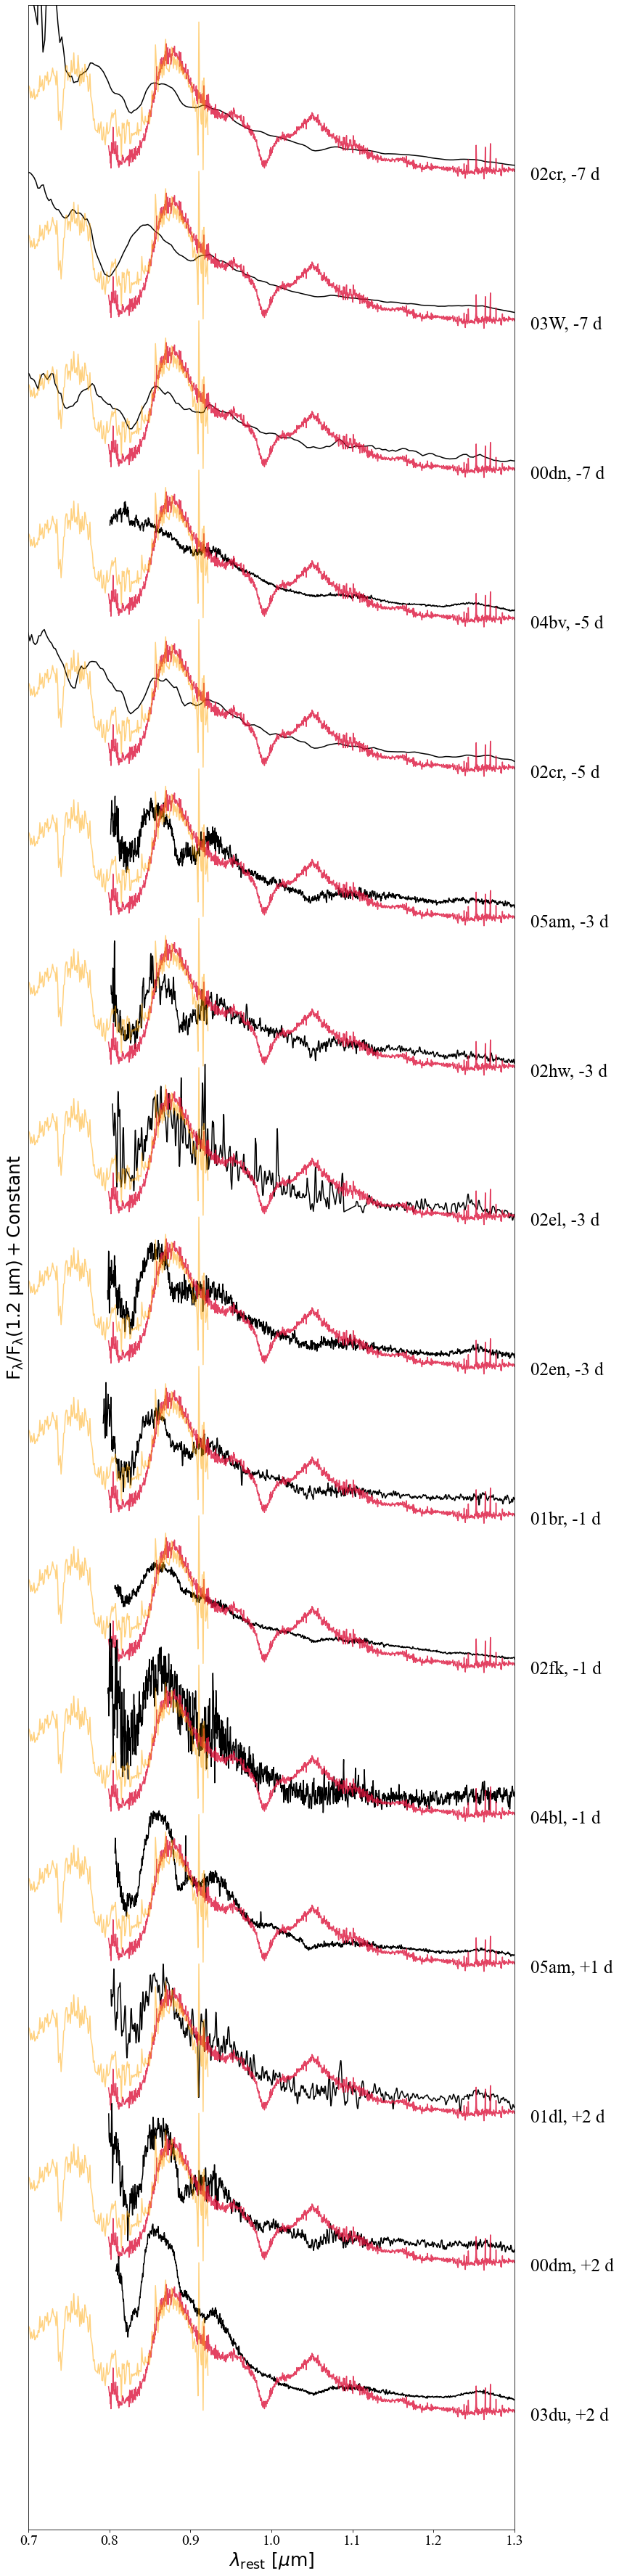

In [38]:
norm_G = flux_G[np.abs(wv_G - 1.0) < 0.05].mean()

depth = 3
arg_p = np.argsort(Phase)
arg_l = np.argwhere((Phase[arg_p] >= -7) & (Phase[arg_p] < 5)).flatten()
plt.figure(figsize=(12, 4 * len(arg_l)))
for k in range(len(arg_l)):
    norm = flux[arg_p][arg_l[k]][np.abs(wv[arg_p][arg_l[k]] -
                                        1.0) < 0.05].mean()
    plt.plot(wv[arg_p][arg_l[k]],
             flux[arg_p][arg_l[k]] / norm - depth * k,
             color='k')
    plt.plot(wv_G, flux_G / norm_G - depth * k, color='crimson', alpha=0.8)
    plt.plot(wv_P, flux_P / norm_G - depth * k, color='orange', alpha=0.5)
    if Phase[arg_p][arg_l[k]] >= 0:
        p = '+{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    else:
        p = '{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    plt.text(1.32, 0.1 - depth * k, '{}, {}'.format(SN[arg_p][arg_l[k]], p))
plt.ylim(-depth * (len(arg_l) - 0.3), depth * 1.2)
plt.xlim(0.7, 1.3)
plt.yticks([])
plt.xlabel('$\lambda_\mathrm{rest}\ [\mu\mathrm{m}]$')
plt.ylabel(
    '$\mathrm{F_\lambda/F_\lambda(1.2\ \mu\mathrm{m})}+\mathrm{Constant}$')

Text(0, 0.5, '$\\mathrm{F_\\lambda/F_\\lambda(1.2\\ \\mu\\mathrm{m})}+\\mathrm{Constant}$')

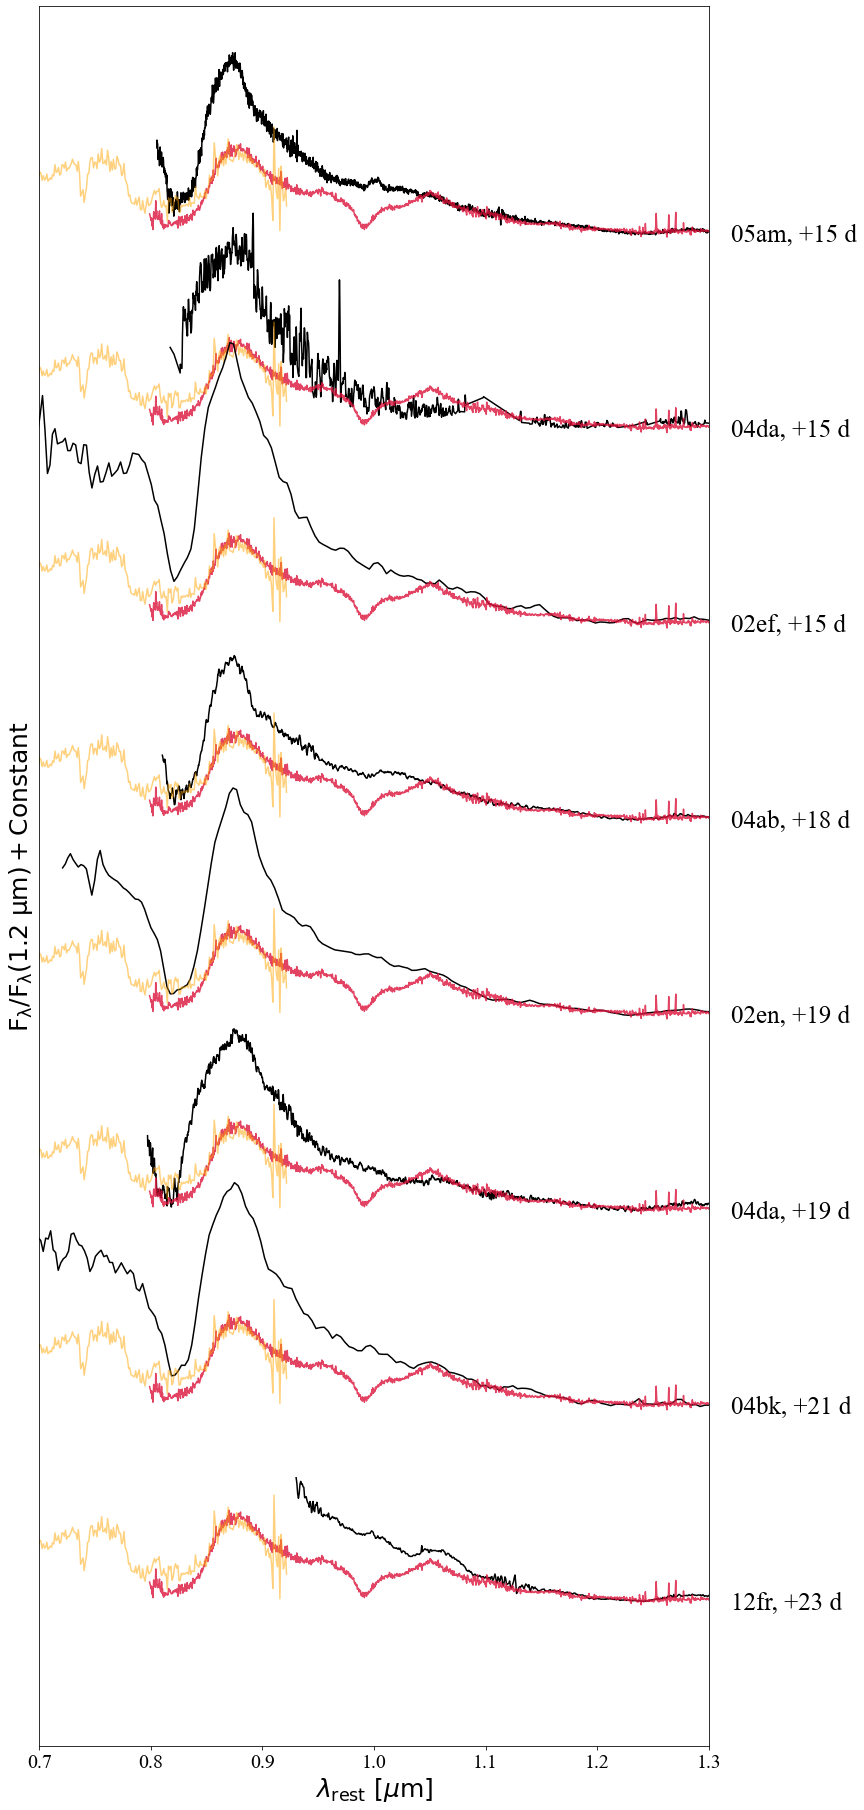

In [39]:
norm_G = flux_G[np.abs(wv_G - 1.2) < 0.05].mean()

depth = 16
arg_p = np.argsort(Phase)
arg_l = np.argwhere((Phase[arg_p] >= 15) & (Phase[arg_p] < 25)).flatten()
plt.figure(figsize=(12, 4 * len(arg_l)))
for k in range(len(arg_l)):
    norm = flux[arg_p][arg_l[k]][np.abs(wv[arg_p][arg_l[k]] -
                                        1.2) < 0.05].mean()
    plt.plot(wv[arg_p][arg_l[k]],
             flux[arg_p][arg_l[k]] / norm - depth * k,
             color='k')
    plt.plot(wv_G, flux_G / norm_G - depth * k, color='crimson', alpha=0.8)
    plt.plot(wv_P, flux_P / norm_G - depth * k, color='orange', alpha=0.5)
    if Phase[arg_p][arg_l[k]] >= 0:
        p = '+{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    else:
        p = '{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    plt.text(1.32, 0.1 - depth * k, '{}, {}'.format(SN[arg_p][arg_l[k]], p))
plt.ylim(-depth * (len(arg_l) - 0.3), depth * 1.2)
plt.xlim(0.7, 1.3)
plt.yticks([])
plt.xlabel('$\lambda_\mathrm{rest}\ [\mu\mathrm{m}]$')
plt.ylabel(
    '$\mathrm{F_\lambda/F_\lambda(1.2\ \mu\mathrm{m})}+\mathrm{Constant}$')

Text(0, 0.5, '$\\mathrm{F_\\lambda/F_\\lambda(1.2\\ \\mu\\mathrm{m})}+\\mathrm{Constant}$')

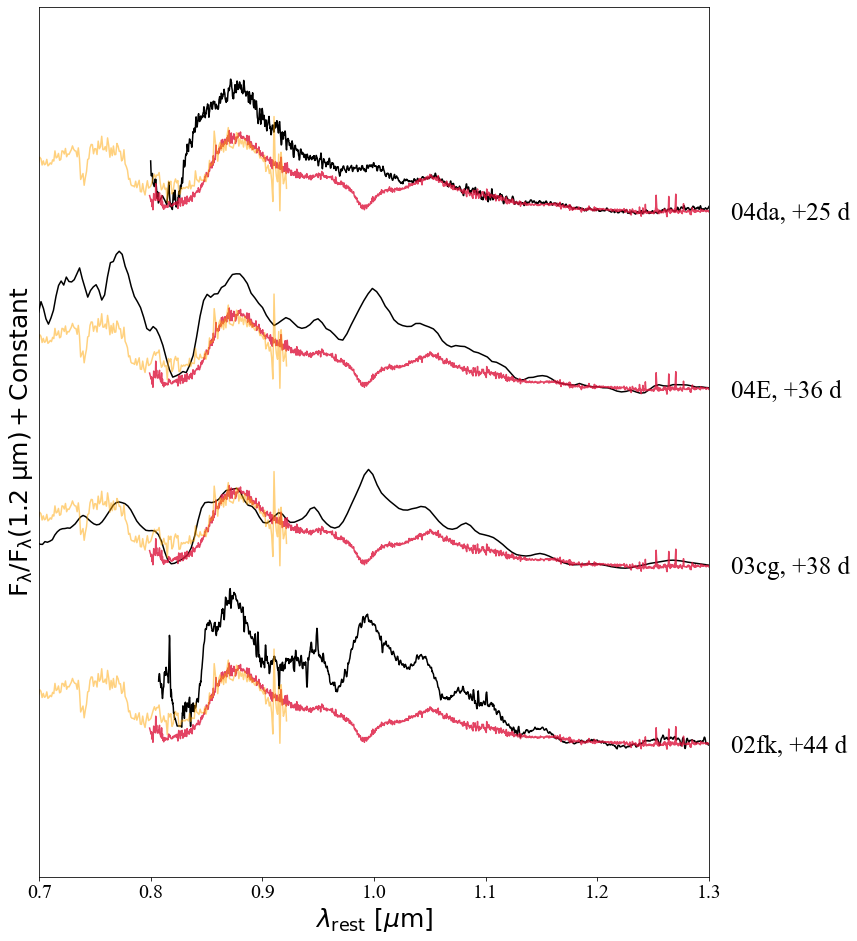

In [40]:
norm_G = flux_G[np.abs(wv_G - 1.2) < 0.05].mean()

depth = 16
arg_p = np.argsort(Phase)
arg_l = np.argwhere((Phase[arg_p] >= 25) & (Phase[arg_p] < 45)).flatten()
plt.figure(figsize=(12, 4 * len(arg_l)))
for k in range(len(arg_l)):
    norm = flux[arg_p][arg_l[k]][np.abs(wv[arg_p][arg_l[k]] -
                                        1.2) < 0.05].mean()
    plt.plot(wv[arg_p][arg_l[k]],
             flux[arg_p][arg_l[k]] / norm - depth * k,
             color='k')
    plt.plot(wv_G, flux_G / norm_G - depth * k, color='crimson', alpha=0.8)
    plt.plot(wv_P, flux_P / norm_G - depth * k, color='orange', alpha=0.5)
    if Phase[arg_p][arg_l[k]] >= 0:
        p = '+{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    else:
        p = '{:.0f} d'.format(Phase[arg_p][arg_l[k]])
    plt.text(1.32, 0.1 - depth * k, '{}, {}'.format(SN[arg_p][arg_l[k]], p))
plt.ylim(-depth * (len(arg_l) - 0.3), depth * 1.2)
plt.xlim(0.7, 1.3)
plt.yticks([])
plt.xlabel('$\lambda_\mathrm{rest}\ [\mu\mathrm{m}]$')
plt.ylabel(
    '$\mathrm{F_\lambda/F_\lambda(1.2\ \mu\mathrm{m})}+\mathrm{Constant}$')

# Fit Ca II triplets

In [10]:
import sys
sys.path.append('../rv/')
import absorption_line_vel as vel
from absorption_line_vel import SpectrumSN_Lines, AbsorbLine

In [11]:
sn = np.loadtxt('../../cat09/04bk_040508.flm')[:, 1:]
sn[:, 0] = sn[:, 0] * 10000  #micron to angstrom
np.savetxt('../../cat09/SN2004bk_20040508.ascii', sn, fmt='%.5e')

sn = np.loadtxt('../../cat09/02ef_020820.flm')[:, 1:]
sn[:, 0] = sn[:, 0] * 10000  #micron to angstrom
np.savetxt('../../cat09/SN2002ef_20020820.ascii', sn, fmt='%.5e')

sn = np.loadtxt('../../cat09/02en_011030.flm')[:, 1:]
sn[:, 0] = sn[:, 0] * 10000  #micron to angstrom
np.savetxt('../../cat09/SN2002en_20011030.ascii', sn, fmt='%.5e')

## SN2004bk

48 points within 7400.00 and 8750.00 angstroms.


/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/../rv/absorption_line_vel.py:150: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


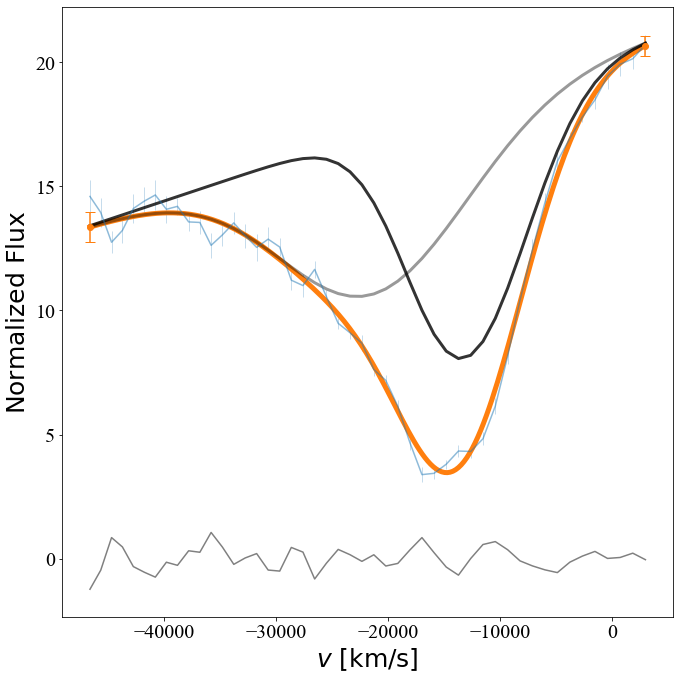

LS estimation:
Velocity pvf: -9546 km/s
Velocity hvf: -17786 km/s


In [12]:
Spec = SpectrumSN_Lines('../../cat09/SN2004bk_20040508.ascii', 0) #wavelength already in rest frame
Spec.add_line('CaII_IRT', 7400, 8750, lines=[8498.018, 8542.089, 8662.140])
Spec.line['CaII_IRT'].LS_estimator(guess=(1, 1, -12000, 15, -1000, -25000, 15, -1000))

## SN2002ef

39 points within 7600.00 and 8750.00 angstroms.


/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/../rv/absorption_line_vel.py:150: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


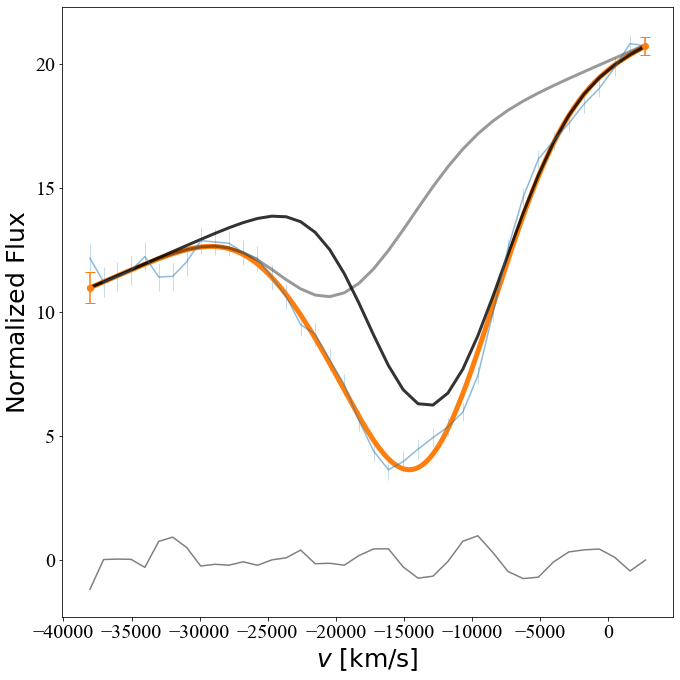

LS estimation:
Velocity pvf: -9168 km/s
Velocity hvf: -15825 km/s


In [13]:
Spec = SpectrumSN_Lines('../../cat09/SN2002ef_20020820.ascii', 0) #wavelength already in rest frame
Spec.add_line('CaII_IRT', 7600, 8750, lines=[8498.018, 8542.089, 8662.140])
Spec.line['CaII_IRT'].LS_estimator(guess=(1, 1, -12000, 15, -1000, -25000, 15, -1000))

## SN2002en

47 points within 7400.00 and 8750.00 angstroms.


/Users/chang/Desktop/SNIa/SN2020jgb/spectroscopy/../rv/absorption_line_vel.py:150: UserWarning: <=5 points within the wavelength range!
  warnings.warn(


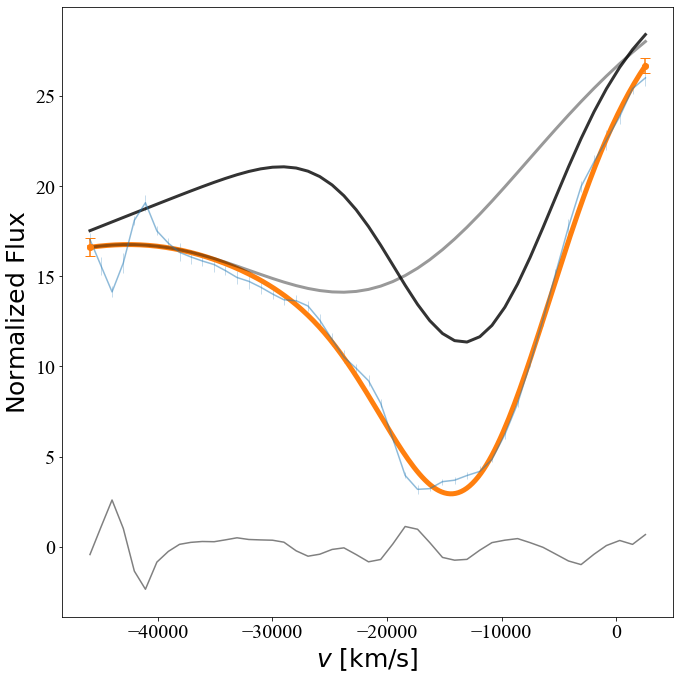

LS estimation:
Velocity pvf: -9091 km/s
Velocity hvf: -16497 km/s


In [14]:
Spec = SpectrumSN_Lines('../../cat09/SN2002en_20011030.ascii', 0) #wavelength already in rest frame
Spec.add_line('CaII_IRT', 7400, 8750, lines=[8498.018, 8542.089, 8662.140])
Spec.line['CaII_IRT'].LS_estimator(guess=(1, 1, -12000, 15, -1000, -25000, 15, -1000))